In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight

In [2]:
def preprocess_image_with_edges(img):
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        gray = img
    edges = cv2.Canny(gray, 100, 200)
    blurred = cv2.GaussianBlur(edges, (5, 5), 0)
    normalized = cv2.normalize(blurred, None, 0, 255, cv2.NORM_MINMAX)
    resized = cv2.resize(normalized, (128, 128))
    expanded = np.expand_dims(resized, axis=-1)
    return expanded

def load_and_preprocess_data(dataset_path):
    images = []
    labels = []
    
    # Define subfolder paths
    pothole_dir = os.path.join(dataset_path, 'potholes')
    normal_dir = os.path.join(dataset_path, 'normal')
    
    # Load pothole images (label = 1)
    if os.path.exists(pothole_dir):
        for img_name in os.listdir(pothole_dir):
            if img_name.endswith('.jpg'):  # Filter for .jpg files
                img_path = os.path.join(pothole_dir, img_name)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    processed_img = preprocess_image_with_edges(img)
                    images.append(processed_img)
                    labels.append(1)  # Pothole
    
    # Load normal images (label = 0)
    if os.path.exists(normal_dir):
        for img_name in os.listdir(normal_dir):
            if img_name.endswith('.jpg'):  # Filter for .jpg files
                img_path = os.path.join(normal_dir, img_name)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    processed_img = preprocess_image_with_edges(img)
                    images.append(processed_img)
                    labels.append(0)  # No pothole
    
    return np.array(images), np.array(labels)

In [3]:
def create_model():
    model = Sequential([
        Conv2D(16, (3, 3), activation='relu', input_shape=(128, 128, 1)),
        MaxPooling2D((2, 2)),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),  # Added dropout for regularization
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [4]:
def train_model(model, X_train, y_train, X_test, y_test):
    datagen = ImageDataGenerator(
        rotation_range=20,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )
    
    # Compute class weights for balanced training using scikit-learn
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weight_dict = dict(enumerate(class_weights))
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, min_delta=0.001)
    
    history = model.fit(
        datagen.flow(X_train, y_train, batch_size=32),
        validation_data=(X_test, y_test),
        epochs=50,
        callbacks=[early_stopping],
        class_weight=class_weight_dict  # Use class weights
    )
    return history

In [5]:
def detect_potholes_realtime(model):
    cap = cv2.VideoCapture(0)
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        processed_frame = preprocess_image_with_edges(frame)
        input_frame = processed_frame.reshape(1, 128, 128, 1) / 255.0
        prediction = model.predict(input_frame)
        original_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        if prediction[0][0] > 0.5:
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            edges = cv2.Canny(gray, 100, 200)
            contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            if contours:
                largest_contour = max(contours, key=cv2.contourArea)
                x, y, w, h = cv2.boundingRect(largest_contour)
                cv2.rectangle(original_frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
                width_cm = w  # Adjust this scaling factor based on your camera and real-world distance
                height_cm = h  # Adjust this scaling factor based on your camera and real-world distance
                text = f'Pothole: {width_cm}cm x {height_cm}cm'
                cv2.putText(original_frame, text, (x, y-10), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
            else:
                cv2.putText(original_frame, 'Pothole Detected', (50, 50),
                           cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        else:
            cv2.putText(original_frame, 'No Pothole', (50, 50),
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
        cv2.imshow('Pothole Detection', cv2.cvtColor(original_frame, cv2.COLOR_RGB2BGR))
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

Fold 1
Epoch 1/50


c:\Users\Srikrishna\pothole_detection_project\pothole_env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Srikrishna\pothole_detection_project\pothole_env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.5607 - loss: 0.7036 - val_accuracy: 0.7132 - val_loss: 0.5642
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.7136 - loss: 0.5904 - val_accuracy: 0.7279 - val_loss: 0.5188
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.7084 - loss: 0.5674 - val_accuracy: 0.7868 - val_loss: 0.4817
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.7753 - loss: 0.5177 - val_accuracy: 0.8015 - val_loss: 0.4236
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.7497 - loss: 0.5149 - val_accuracy: 0.8235 - val_loss: 0.4259
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - accuracy: 0.7622 - loss: 0.5223 - val_accuracy: 0.8309 - val_loss: 0.4278
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.7723 - loss: 0.5312 - val_accuracy: 0.8309 - val_loss: 0.4136
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.7906 - loss: 0.4730 - val_accuracy: 0.8162 - val_loss:

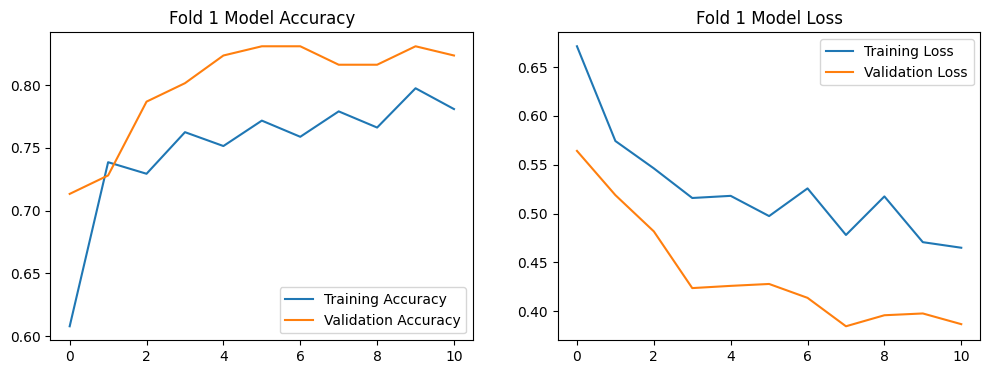

Fold 2
Epoch 1/50


c:\Users\Srikrishna\pothole_detection_project\pothole_env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Srikrishna\pothole_detection_project\pothole_env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.5610 - loss: 0.6726 - val_accuracy: 0.7647 - val_loss: 0.5269
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.6973 - loss: 0.5856 - val_accuracy: 0.7941 - val_loss: 0.4476
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.6755 - loss: 0.6056 - val_accuracy: 0.8162 - val_loss: 0.4165
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.7149 - loss: 0.5633 - val_accuracy: 0.7794 - val_loss: 0.4385
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.7171 - loss: 0.5573 - val_accuracy: 0.8162 - val_loss: 0.4128
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.7572 - loss: 0.4977 - val_accuracy: 0.8309 - val_loss: 0.3751
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.7351 - loss: 0.5136 - val_accuracy: 0.8456 - val_loss: 0.3537
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.7579 - loss: 0.5191 - val_accuracy: 0.8456 - val_loss: 0.

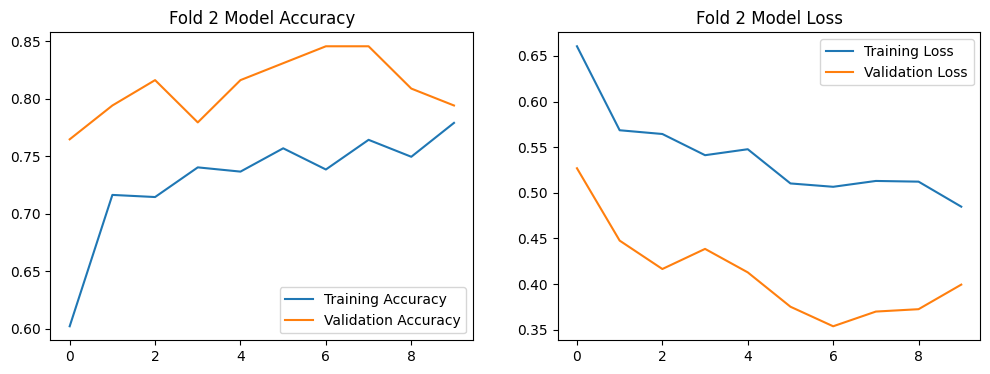

Fold 3
Epoch 1/50


c:\Users\Srikrishna\pothole_detection_project\pothole_env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Srikrishna\pothole_detection_project\pothole_env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.5165 - loss: 0.8732 - val_accuracy: 0.7353 - val_loss: 0.5564
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.7339 - loss: 0.5909 - val_accuracy: 0.7426 - val_loss: 0.5238
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.7424 - loss: 0.5353 - val_accuracy: 0.7647 - val_loss: 0.4637
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.7486 - loss: 0.5203 - val_accuracy: 0.7721 - val_loss: 0.4444
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.7519 - loss: 0.5532 - val_accuracy: 0.7868 - val_loss: 0.4250
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.7554 - loss: 0.5242 - val_accuracy: 0.7868 - val_loss: 0.4069
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.7679 - loss: 0.5043 - val_accuracy: 0.7868 - val_loss: 0.4086
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.7455 - loss: 0.5162 - val_accuracy: 0.7941 - val_loss: 0.

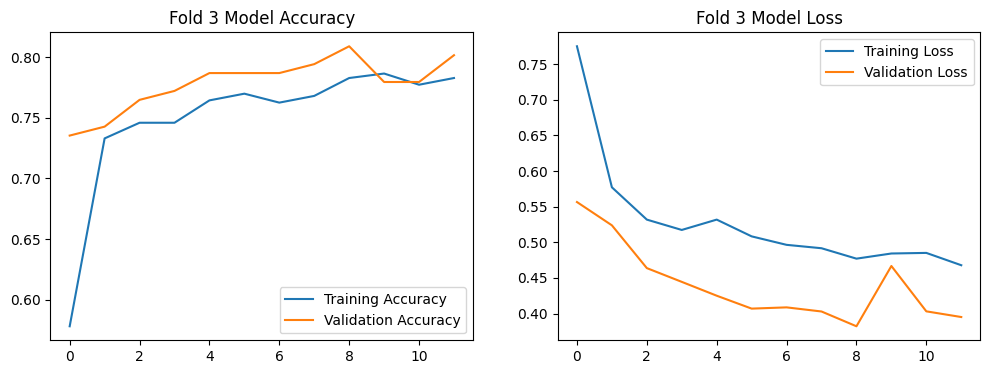

Fold 4
Epoch 1/50


c:\Users\Srikrishna\pothole_detection_project\pothole_env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Srikrishna\pothole_detection_project\pothole_env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.6006 - loss: 0.6808 - val_accuracy: 0.7132 - val_loss: 0.5445
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.7143 - loss: 0.5727 - val_accuracy: 0.7353 - val_loss: 0.5561
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.7412 - loss: 0.5580 - val_accuracy: 0.7941 - val_loss: 0.4975
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.7601 - loss: 0.5111 - val_accuracy: 0.7868 - val_loss: 0.4766
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.7684 - loss: 0.4731 - val_accuracy: 0.7500 - val_loss: 0.5102
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.7437 - loss: 0.5093 - val_accuracy: 0.7500 - val_loss: 0.5016
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.7798 - loss: 0.5153 - val_accuracy: 0.7721 - val_loss: 0.4905
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7666 - loss: 0.5392
Fold 4 Test Accuracy: 78.68%


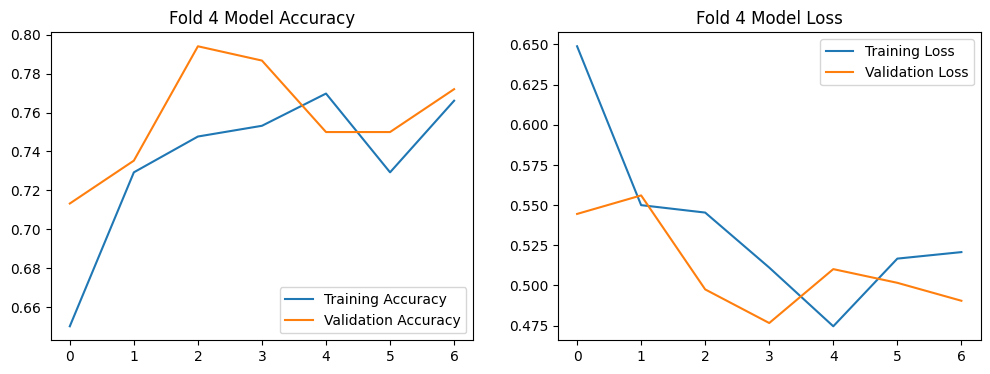

Fold 5
Epoch 1/50


c:\Users\Srikrishna\pothole_detection_project\pothole_env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Srikrishna\pothole_detection_project\pothole_env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 0.5386 - loss: 0.7999 - val_accuracy: 0.7111 - val_loss: 0.6014
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.6823 - loss: 0.6178 - val_accuracy: 0.7556 - val_loss: 0.4915
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.7580 - loss: 0.5058 - val_accuracy: 0.7704 - val_loss: 0.4717
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.7503 - loss: 0.5347 - val_accuracy: 0.7185 - val_loss: 0.5403
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.7316 - loss: 0.5242 - val_accuracy: 0.7407 - val_loss: 0.5465
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.7539 - loss: 0.5166 - val_accuracy: 0.7630 - val_loss: 0.4987
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7737 - loss: 0.4463
Fold 5 Test Accuracy: 77.04%


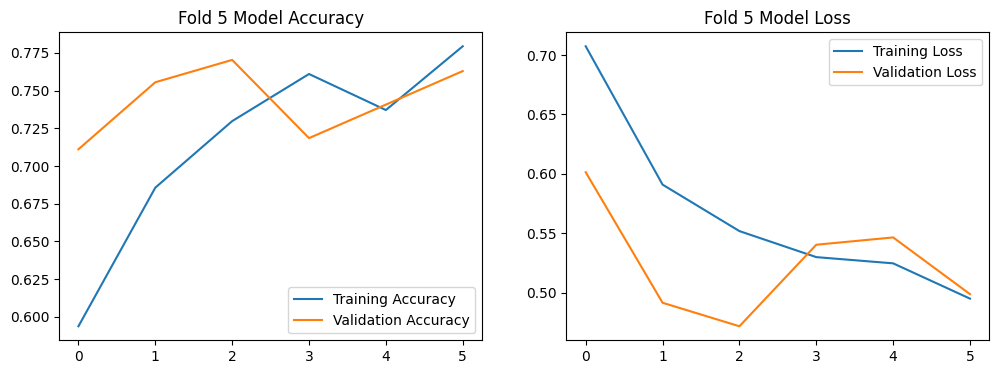

Average Test Accuracy: 80.55%
Epoch 1/50


c:\Users\Srikrishna\pothole_detection_project\pothole_env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Srikrishna\pothole_detection_project\pothole_env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 0.5810 - loss: 0.7686 - val_accuracy: 0.7423 - val_loss: 0.5297
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.7221 - loss: 0.5552 - val_accuracy: 0.7717 - val_loss: 0.4750
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.7175 - loss: 0.5574 - val_accuracy: 0.7732 - val_loss: 0.4556
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.7337 - loss: 0.5199 - val_accuracy: 0.7894 - val_loss: 0.4271
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 0.7431 - loss: 0.5277 - val_accuracy: 0.7923 - val_loss: 0.4248
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.7681 - loss: 0.4872 - val_accuracy: 0.8247 - val_loss: 0.4231
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.7610 - loss: 0.5103 - val_accuracy: 0.7953 - val_loss: 0.4121
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.7825 - loss: 0.4761 - val_accuracy: 0.8218 - val_loss: 0

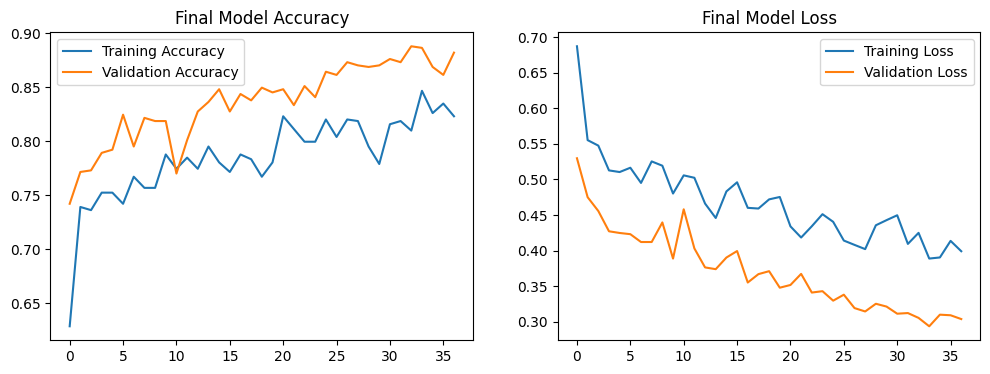

In [6]:
# Load and preprocess data
dataset_path = 'pothole_image_data'
X, y = load_and_preprocess_data(dataset_path)
X = X / 255.0

# Perform k-fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
accuracies = []

for train_index, test_index in kfold.split(X):
    print(f'Fold {fold}')
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Create and train model
    model = create_model()
    history = train_model(model, X_train, y_train, X_test, y_test)
    
    # Evaluate model
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f"Fold {fold} Test Accuracy: {accuracy * 100:.2f}%")
    accuracies.append(accuracy)
    
    # Plot training history for this fold
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Fold {fold} Model Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Fold {fold} Model Loss')
    plt.legend()
    plt.show()
    
    fold += 1

# Print average accuracy across folds
print(f'Average Test Accuracy: {np.mean(accuracies) * 100:.2f}%')

# Use the last trained model for real-time detection (or train one final model on all data)
final_model = create_model()
final_history = train_model(final_model, X, y, X, y)  # Train on all data for deployment

# Evaluate final model (optional, since we used cross-validation)
loss, accuracy = final_model.evaluate(X, y)
print(f"Final Model Accuracy: {accuracy * 100:.2f}%")

# Plot final training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(final_history.history['accuracy'], label='Training Accuracy')
plt.plot(final_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Final Model Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(final_history.history['loss'], label='Training Loss')
plt.plot(final_history.history['val_loss'], label='Validation Loss')
plt.title('Final Model Loss')
plt.legend()
plt.show()

In [7]:
# Start real-time detection with the final model
detect_potholes_realtime(final_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━